In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "KoddiUD 온고딕"
    }
</style>

In [60]:
# 라이브러리 로드
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
import networkx as nx

In [3]:
# 한글 폰트 설정

# pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

/opt/homebrew/Caskroom/miniforge/base/envs/eda_kaggle/lib/python3.12/site-packages/koreanize_matplotlib/koreanize_matplotlib.py:16: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/homebrew/Caskroom/miniforge/base/envs/eda_kaggle/lib/python3.12/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# 0. 데이터 불러오기

- 데이터 출처
  - [Kaggle](https://www.kaggle.com/datasets/akashdeepkuila/bakery/data) `Bakery Sales Dataset`
- 데이터 명세
  
  |No.|컬럼명|설명|
  |----|----|----|
  |1| Transaction| 거래 ID|
  |2| Item| 구매한 제품명|
  |3| date_time| 거래 날짜 및 시각 |
  |4| period_day| 아침/오후/저녁/밤 중 언제 구매했는지 여부|
  |5| weekday_weekend| 주중/주말 중 언제 구매했는지 여부|

In [4]:
df = pd.read_csv('bakery_sales_revised.csv')
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,10/30/2016 9:58,morning,weekend
1,2,Scandinavian,10/30/2016 10:05,morning,weekend
2,2,Scandinavian,10/30/2016 10:05,morning,weekend
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend
4,3,Jam,10/30/2016 10:07,morning,weekend


# 1. 데이터 살펴보기

## 1.1 기본 정보 확인

In [5]:
print("[Data Dimension]\n", df.shape)
print("\n[Data Describe]\n", df.describe(include=object))
print("\n[Data info]\n", df.info)

[Data Dimension]
 (20507, 5)

[Data Describe]
           Item       date_time period_day weekday_weekend
count    20507           20507      20507           20507
unique      94            9182          4               2
top     Coffee  2/5/2017 11:58  afternoon         weekday
freq      5471              12      11569           12807

[Data info]
 <bound method DataFrame.info of        Transaction           Item         date_time period_day weekday_weekend
0                1          Bread   10/30/2016 9:58    morning         weekend
1                2   Scandinavian  10/30/2016 10:05    morning         weekend
2                2   Scandinavian  10/30/2016 10:05    morning         weekend
3                3  Hot chocolate  10/30/2016 10:07    morning         weekend
4                3            Jam  10/30/2016 10:07    morning         weekend
...            ...            ...               ...        ...             ...
20502         9682         Coffee    4/9/2017 14:32  afternoon  

- dtype
  - 문자형으로 되어있음 &rarr; datetype으로 전처리 해야함
- Transaction
  - 10/30/2016 ~ 4/9/2017까지의 데이터
  - &rarr; 월별 분석을 진행한다면 10, 4월 제외 11~3월 데이터만 분석하는 것이 좋을 듯함

In [6]:
df['Transaction'].nunique()

9465

- 총 9465개의 구매건

## 1.2 결측치 확인

In [7]:
df.isna().sum()

Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
dtype: int64

- 결측치 없음

## 1.3 중복값 확인

In [8]:
df.duplicated().sum()

np.int64(1620)

In [9]:
df[df.duplicated(keep=False)]

,Transaction,Item,date_time,period_day,weekday_weekend
1,2,Scandinavian,10/30/2016 10:05,morning,weekend
2,2,Scandinavian,10/30/2016 10:05,morning,weekend
23,11,Bread,10/30/2016 10:27,morning,weekend
25,11,Bread,10/30/2016 10:27,morning,weekend
48,21,Coffee,10/30/2016 10:49,morning,weekend
...,...,...,...,...,...
20423,9634,Coffee,4/8/2017 16:30,afternoon,weekend
20464,9664,Coffee,4/9/2017 11:40,morning,weekend
20465,9664,Coffee,4/9/2017 11:40,morning,weekend
20472,9667,Sandwich,4/9/2017 12:04,afternoon,weekend


- 구매 개수 칼럼이 없는 것으로 보아 동일 품목을 여러 개 구매한 건이 중복으로 처리됨
  - 중복값 제거하지 않고 구매 개수 컬럼을 만들어 처리

# 2. 전처리

## 2.1 구매 수량 파생 변수 만들기

In [10]:
# 필요한 column 추가
df['Quantity'] = 1

# 그룹화 및 집계
df = df.groupby([
    'Transaction', 'Item', 'date_time', 'period_day', 'weekday_weekend'
]).agg({
    'Quantity': 'sum'
}).reset_index()
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
0,1,Bread,10/30/2016 9:58,morning,weekend,1
1,2,Scandinavian,10/30/2016 10:05,morning,weekend,2
2,3,Cookies,10/30/2016 10:07,morning,weekend,1
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend,1
4,3,Jam,10/30/2016 10:07,morning,weekend,1


In [11]:
df.duplicated().sum()

np.int64(0)

## 2.2 DateTime 전처리

In [12]:
dateTime=pd.to_datetime(df['date_time'])
df['Day']=dateTime.dt.day_name()
df['Month']=dateTime.dt.month_name()
df['Year']=dateTime.dt.year
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity,Day,Month,Year
0,1,Bread,10/30/2016 9:58,morning,weekend,1,Sunday,October,2016
1,2,Scandinavian,10/30/2016 10:05,morning,weekend,2,Sunday,October,2016
2,3,Cookies,10/30/2016 10:07,morning,weekend,1,Sunday,October,2016
3,3,Hot chocolate,10/30/2016 10:07,morning,weekend,1,Sunday,October,2016
4,3,Jam,10/30/2016 10:07,morning,weekend,1,Sunday,October,2016


# 3. 메뉴에 따른 분석

## 3.1 품목별 판매량

In [13]:
itemFrequency = df['Item'].value_counts().sort_values(ascending=False)
itemFrequency

Item
Coffee            4528
Bread             3097
Tea               1350
Cake               983
Pastry             815
                  ... 
Bacon                1
Gift voucher         1
Olum & polenta       1
Raw bars             1
Polenta              1
Name: count, Length: 94, dtype: int64

In [14]:
fig = px.bar(itemFrequency.head(20), title='가장 잘 팔리는 메뉴 20가지', color=itemFrequency.head(20), color_continuous_scale=px.colors.sequential.Blues_r)
fig.update_layout(margin=dict(t=50, b=0, l=0, r=0), titlefont=dict(size=20), xaxis_tickangle=-45, coloraxis_showscale=False)
fig.update_yaxes(showticklabels=False, title=' ')
fig.update_xaxes(title=' ')
fig.show()

In [15]:
fig = px.bar(itemFrequency, title='메뉴별 판매량', color=itemFrequency, color_continuous_scale=px.colors.sequential.Blues_r)
fig.update_layout(margin=dict(t=50, b=0, l=0, r=0), titlefont=dict(size=20), xaxis_tickangle=-45, coloraxis_showscale=False)
fig.update_yaxes(showticklabels=False, title=' ')
fig.update_xaxes(title='menus')
fig.show()

In [16]:
fig = px.box(itemFrequency, y='count', title='메뉴별 판매량')
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0), 
    titlefont=dict(size=20),
    xaxis_tickangle=-45
)
fig.update_yaxes(showticklabels=False, title=' ')
fig.update_xaxes(title='menus')
fig.show()

### 판매율이 저조한 상품 정의
- Q1(하위 25%) 미만 제품 

In [17]:
itemFrequency = itemFrequency.reset_index()
itemFrequency.columns = ['Item', 'Sales']

itemFrequency

,Item,Sales
0,Coffee,4528
1,Bread,3097
2,Tea,1350
3,Cake,983
4,Pastry,815
...,...,...
89,Bacon,1
90,Gift voucher,1
91,Olum & polenta,1
92,Raw bars,1


In [18]:
# 25% 백분위수(Q1) 계산
Q1 = itemFrequency['Sales'].quantile(0.25)

# 하위 25% 미만인 제품 필터링
low_selling_items = itemFrequency[itemFrequency['Sales'] < Q1]
low_selling_items.reset_index(drop=True)


,Item,Sales
0,Panatone,5
1,Mortimer,5
2,Bare Popcorn,5
3,Bread Pudding,4
4,Caramel bites,3
5,Brioche and salami,3
6,Cherry me Dried fruit,3
7,Raspberry shortbread sandwich,3
8,Bowl Nic Pitt,2
9,Siblings,2


- 총 판매 수가 5 이하인 상품

## 4. 날짜, 시간에 따른 분석

In [19]:
# 시간 살펴보기
peakHours = df.groupby('period_day')['Item'].count().sort_values(ascending=False)
peakHours

period_day
afternoon    10687
morning       7697
evening        490
night           13
Name: Item, dtype: int64

In [20]:
fig = go.Figure(data=[go.Pie(labels=['Afternoon','Morning','Evening','Night'],
                values=peakHours, title="판매 시간",titlefont=dict(size=20), textinfo='label+percent', marker=dict(colors=px.colors.sequential.Blues_r), hole=.5)])
fig.update_layout(margin=dict(t=40, b=40, l=0, r=0), font=dict(size=13), showlegend=False)
fig.show()

- 오후에 56%로 가장 많이 팔림
- 아침도 그와 비슷(41%)
- 저녁(2.54%)과 밤(0.0683)은 적게 팔림
  - 오후에 일찍 닫는 것일 수도 있음

In [21]:
mpd = df.groupby('Day')['Item'].count().sort_values(ascending=False)
mpd

Day
Saturday     4259
Friday       2866
Sunday       2798
Thursday     2458
Tuesday      2212
Wednesday    2150
Monday       2144
Name: Item, dtype: int64

In [22]:
fig = px.bar(mpd, title='요일별 판매', color=mpd, color_continuous_scale=px.colors.sequential.Blues)
fig.update_layout(margin=dict(t=50, b=0, l=0, r=0), titlefont=dict(size=20), xaxis_tickangle=0, coloraxis_showscale=False)
fig.update_yaxes(showticklabels=False, title=' ')
fig.update_xaxes(title=' ')
fig.update_traces(texttemplate='%{y}', textposition='outside', hovertemplate = '<b>%{x}</b><br>No. of Transactions: %{y}')
fig.show()

- 주말과 금요일에 잘 팔림
- 그 외 요일들은 비슷

In [23]:
mpm = df.groupby('Month')['Item'].count().sort_values(ascending=False)
mpm

Month
November    4172
March       3658
February    3421
January     3128
December    3076
April       1086
October      346
Name: Item, dtype: int64

In [24]:
fig = px.bar(mpm, title='월 별 판매', color=mpm, color_continuous_scale=px.colors.sequential.Blues)
fig.update_layout(margin=dict(t=50, b=0, l=0, r=0), titlefont=dict(size=20), xaxis_tickangle=0, coloraxis_showscale=False)
fig.update_yaxes(showticklabels=False, title=' ')
fig.update_xaxes(title=' ')
fig.update_traces(texttemplate='%{y}', textposition='outside', hovertemplate = '<b>%{x}</b><br>No. of Transactions: %{y}')
fig.show()

- 데이터 수집 기간을 앞서 살펴본 결과 4월과 10월의 데이터가 집계된 기간은 매우 짧았음

**데이터 정리 요약**
- 메뉴별
  - 커피가 가장 잘 팔림
- 시간별
  - 매일 오후나 점심에 많은 매출을 내고 있음
- 요일별
  - 주말 매출이 많음
- 월별
  - 11월부터 3월까지 대부분의 매출을 올리고 있음

In [25]:
df.isnull().sum()

Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
Quantity           0
Day                0
Month              0
Year               0
dtype: int64

In [26]:
duplicated_df = df[df.duplicated()]
duplicated_df

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity,Day,Month,Year


- 1620 중복

In [27]:
print("[Data Dimension]\n", df.shape)
print("\n[Data Describe]\n", df.describe(include=object))
print("\n[Data info]\n", df.info)

[Data Dimension]
 (18887, 9)

[Data Describe]
           Item       date_time period_day weekday_weekend       Day     Month
count    18887           18887      18887           18887     18887     18887
unique      94            9182          4               2         7         7
top     Coffee  4/5/2017 17:22  afternoon         weekday  Saturday  November
freq      4528              10      10687           11830      4259      4172

[Data info]
 <bound method DataFrame.info of        Transaction           Item         date_time period_day  \
0                1          Bread   10/30/2016 9:58    morning   
1                2   Scandinavian  10/30/2016 10:05    morning   
2                3        Cookies  10/30/2016 10:07    morning   
3                3  Hot chocolate  10/30/2016 10:07    morning   
4                3            Jam  10/30/2016 10:07    morning   
...            ...            ...               ...        ...   
18882         9682   Tacos-Fajita    4/9/2017 14:32  af

# 4. 판매율이 저조한 상품 분석
- 앞서 정의했던 판매율이 저조한 상품(하위 25% 이하) 분석

In [28]:
low_selling_items

,Item,Sales
72,Panatone,5
73,Mortimer,5
74,Bare Popcorn,5
75,Bread Pudding,4
76,Caramel bites,3
77,Brioche and salami,3
78,Cherry me Dried fruit,3
79,Raspberry shortbread sandwich,3
80,Bowl Nic Pitt,2
81,Siblings,2


In [29]:
low_selling_df = df[df['Item'].isin(low_selling_items['Item'])]

In [30]:
low_selling_df

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity,Day,Month,Year
136,68,Chicken sand,10/30/2016 13:49,afternoon,weekend,1,Sunday,October,2016
879,475,The BART,11/4/2016 11:10,morning,weekday,1,Friday,November,2016
1136,593,Fairy Doors,11/5/2016 12:22,afternoon,weekend,1,Saturday,November,2016
1675,873,Bowl Nic Pitt,11/8/2016 14:36,afternoon,weekday,1,Tuesday,November,2016
1699,885,Bread Pudding,11/8/2016 16:35,afternoon,weekday,1,Tuesday,November,2016
1772,924,Bread Pudding,11/9/2016 13:24,afternoon,weekday,1,Wednesday,November,2016
1776,926,Bread Pudding,11/9/2016 14:15,afternoon,weekday,1,Wednesday,November,2016
1781,927,Bread Pudding,11/9/2016 14:16,afternoon,weekday,1,Wednesday,November,2016
1804,938,Adjustment,11/9/2016 19:49,evening,weekday,1,Wednesday,November,2016
1939,1000,Chimichurri Oil,11/10/2016 16:11,afternoon,weekday,1,Thursday,November,2016


In [31]:
# 월별 판매량 계산 (수정된 부분)
monthly_sales = low_selling_df.groupby(['Item', 'Month'])['Quantity'].sum().unstack(fill_value=0)

# 모든 그래프의 최대값 찾기
y_max = monthly_sales.max().max()

/opt/homebrew/Caskroom/miniforge/base/envs/eda_kaggle/lib/python3.12/site-packages/matplotlib_inline/config.py:68: DeprecationWarning:

InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.



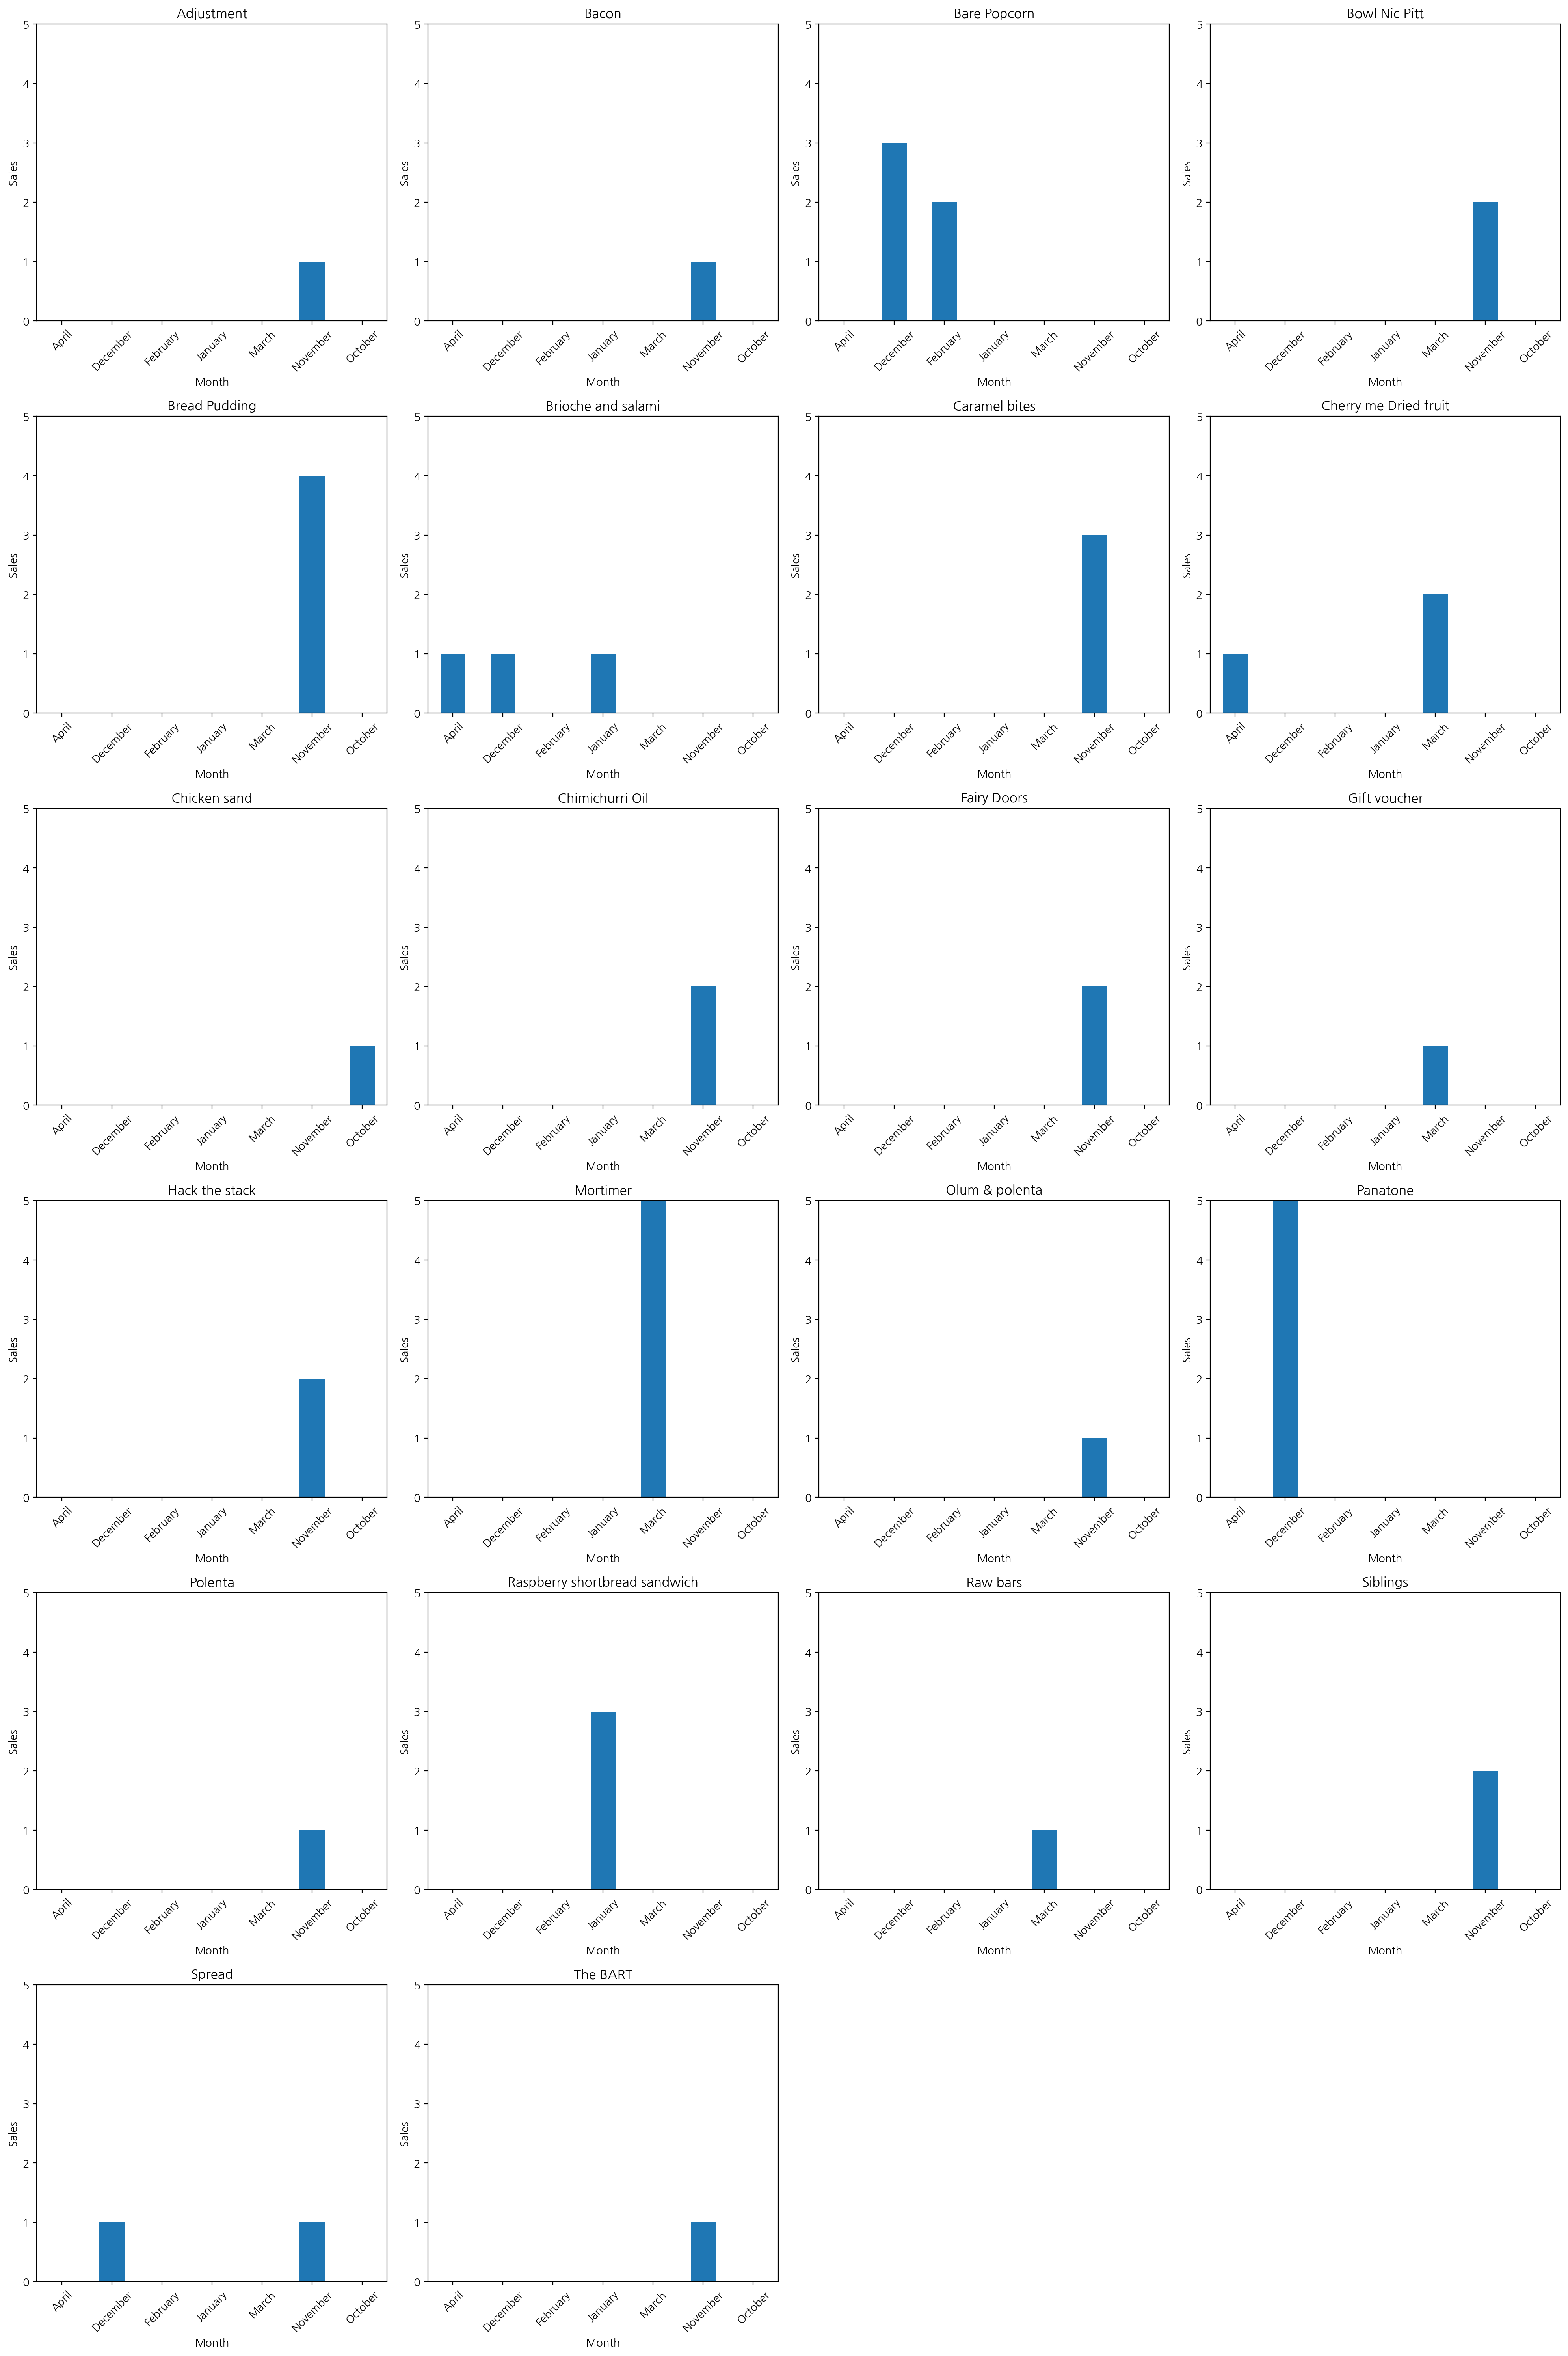

In [32]:
# 시각화
plt.figure(figsize=(20, 30))
for i, item in enumerate(monthly_sales.index, 1):
    plt.subplot(6, 4, i)
    monthly_sales.loc[item].plot(kind='bar')
    plt.title(item)
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.ylim(0, y_max)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

- 판매 패턴 분석
  - 개선 방향
    - 제품 수명주기
      - 대부분의 제품이 특정 월에만 판매되고 있어, 지속적인 판매 전략이 필요
      - 일회성 제품들의 경우, 판매 중단 이유를 분석하여 개선이 필요
      - 한 번만 판매된 제품들도 있는데 이는 테스트 상품이거나 일회성 이벤트 상품으로 예측됨
    - 시즌성 고려
      - 'Spread'항목의 경우 겨울에만 판매되는 시즌 상품인 것으로 보임
      - 'Cherry me Dried Fruit'도 봄에만 판매됨
      - 특정 시즌에 맞춘 제품 출시 시 마케팅 전략 수립이 필요
        - -> 시즌 제품의 판매량 저조가 눈에 띔
      - 비수기에도 판매될 수 있는 방안을 모색

# 4. 장바구니 분석

## 4.1 서로 다른 품목을 2개 이상 구매하는 수

In [33]:
# 구매 건 당 구매 품목 수 
temp = pd.DataFrame(df['Transaction'].value_counts())
temp['count'].mean()

np.float64(1.995456946645536)

In [34]:
temp_count = pd.DataFrame(temp['count'].value_counts())
temp_count

,count
count,
1,3948
2,3059
3,1471
4,662
5,234
6,64
7,17
9,5
8,4


In [35]:
 #count 인덱스 값이 5 이상인 항목들을 합쳐서 '5over'로 묶기
other_sum = temp_count[temp_count.index >= 5]['count'].sum()

# count 인덱스 값이 5 미만인 데이터만 필터링하고, '5over' 추가
temp_count_filtered = temp_count[temp_count.index < 5].copy()
temp_count_filtered.loc['5_over'] = other_sum

temp_count_filtered

,count
count,
1,3948
2,3059
3,1471
4,662
5_over,325


In [36]:
data = {'count': [3948, 3059, 1471, 662, 325],
        'labels': ['1', '2', '3', '4', '5_over']}
temp_count_filtered = pd.DataFrame(data)

temp_count_filtered

,count,labels
0,3948,1
1,3059,2
2,1471,3
3,662,4
4,325,5_over


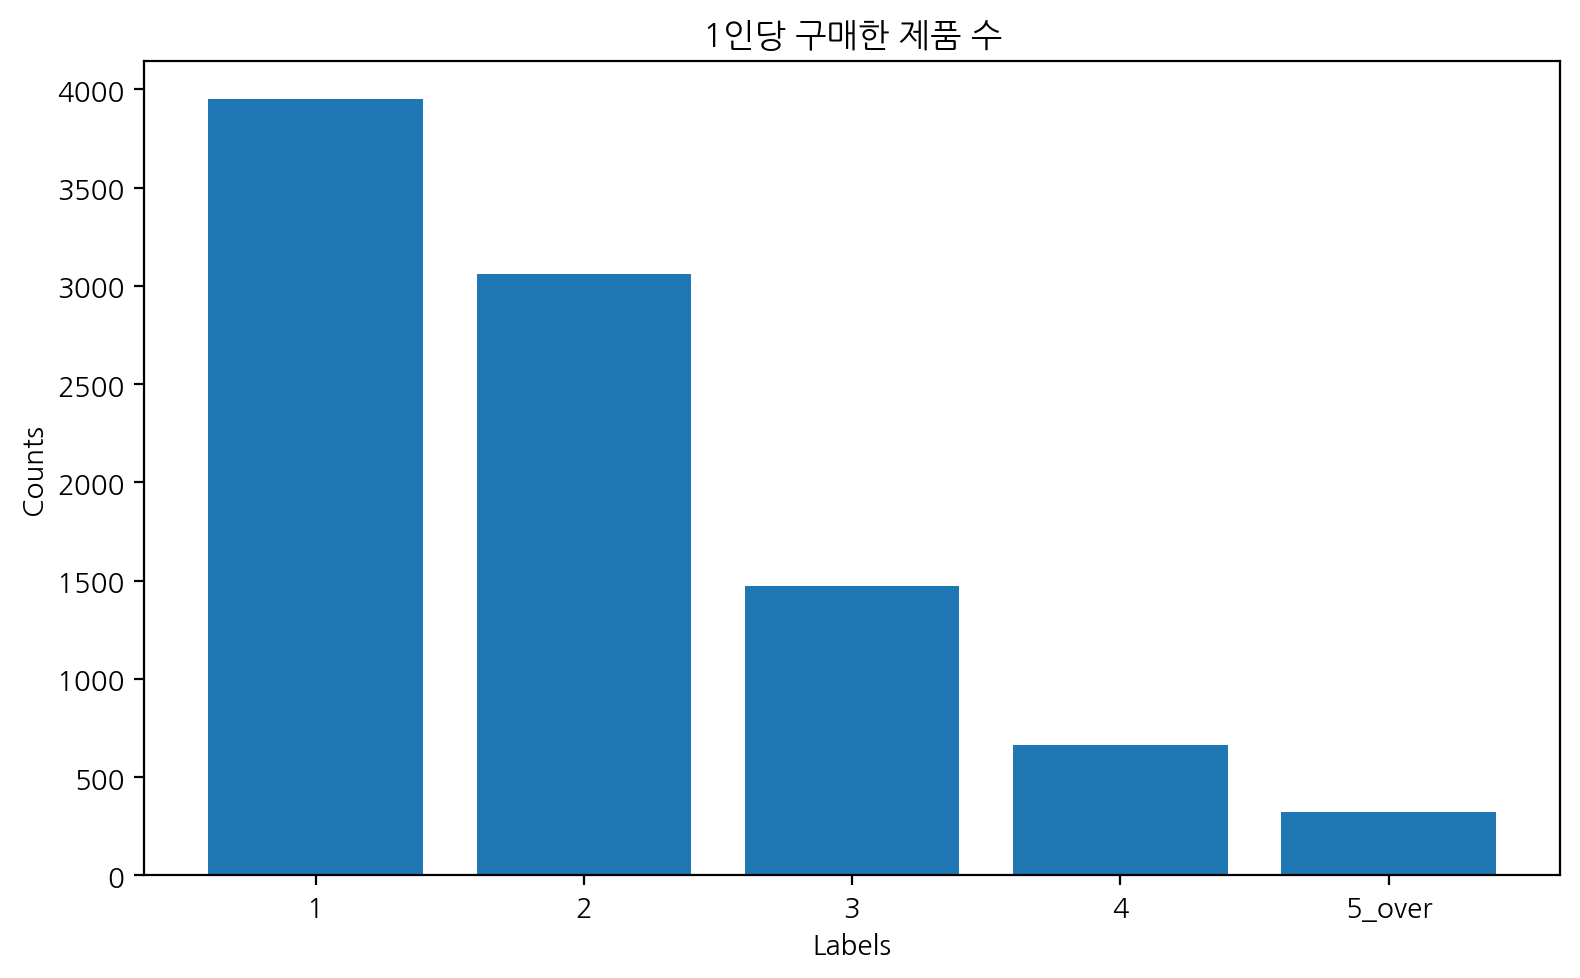

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(temp_count_filtered['labels'], temp_count_filtered['count'])

# 제목과 축 레이블 설정
ax.set_title('1인당 구매한 제품 수')
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')

# x축 라벨 회전 및 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [38]:
# 전체 구매 수 계산
total = temp_count_filtered['count'].sum()

# labels가 1이 아닌 구매 수 계산
non_single = temp_count_filtered[temp_count_filtered.index != 0]['count'].sum()

# 비율 계산
ratio = (non_single / total) * 100
ratio

np.float64(58.288431061806655)

- 한 번 구매할 때, 상품 종류 2개 이상을 구매하는 고객의 비율이 과반수를 넘음(58.288%)
- 1개를 구매하는 사람과 2개 이상을 구매하는 고객의 비율이 비슷하지만 후자가 조금 더 높아(약 16% 높음) 장바구니 분석을 진행할만한 효용성이 있다고 판단

## 4.2 장바구니 분석(연관 분석) 전처리

In [39]:
# 트랜잭션별로 구매한 상품을 묶기
basket_df = df.groupby('Transaction')['Item'].apply(list).reset_index()
basket_df.head()

,Transaction,Item
0,1,[Bread]
1,2,[Scandinavian]
2,3,"[Cookies, Hot chocolate, Jam]"
3,4,[Muffin]
4,5,"[Bread, Coffee, Pastry]"


In [40]:
# 데이터 인코딩
te = TransactionEncoder()
te_result = te.fit_transform(basket_df['Item'])

In [41]:
te_df = pd.DataFrame(te_result, columns=te.columns_)
te_df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 4.3 Apriori 알고리즘

In [42]:
# Apriori 알고리즘 최소지지도 0.01로 설정
ap_frequent_itemsets = apriori(te_df, min_support=0.01, use_colnames=True)
ap_frequent_itemsets

,support,itemsets
0,0.036344,(Alfajores)
1,0.016059,(Baguette)
2,0.327205,(Bread)
3,0.040042,(Brownie)
4,0.103856,(Cake)
...,...,...
56,0.023666,"(Coffee, Toast)"
57,0.014369,"(Sandwich, Tea)"
58,0.010037,"(Cake, Coffee, Bread)"
59,0.011199,"(Coffee, Bread, Pastry)"


In [43]:
ap_frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
6,0.478394,(Coffee)
2,0.327205,(Bread)
26,0.142631,(Tea)
4,0.103856,(Cake)
34,0.090016,"(Coffee, Bread)"


In [57]:
total_transactions = len(te_df)

In [58]:
ap_rules = association_rules(ap_frequent_itemsets, 
                           metric='confidence', 
                           min_threshold=0.5,
                           num_itemsets=total_transactions)
ap_rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,1.0,0.007593,1.764582,0.332006,0.048464,0.433293,0.376936
9,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,1.0,0.002189,1.300235,0.204851,0.022406,0.230908,0.310792
5,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,1.0,0.005614,1.210871,0.170091,0.069665,0.174148,0.321387
6,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,1.0,0.006351,1.164682,0.146161,0.091968,0.141396,0.325764
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,1.0,0.002264,1.135648,0.119574,0.039693,0.119446,0.290888
4,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,1.0,0.002154,1.119919,0.108738,0.041507,0.107078,0.288656
7,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,1.0,0.003877,1.115384,0.109205,0.074701,0.103448,0.306150
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,1.0,0.005044,1.102664,0.102840,0.103745,0.093105,0.320679
8,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,1.0,0.001539,1.093366,0.088224,0.036507,0.085393,0.280350
2,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,1.0,0.002179,1.083174,0.081700,0.055905,0.076787,0.288707


**[결과 분석]**
- 지지도 0.01 이상, 신뢰도 0.5 이상
- 상위의 모든 consequents는 커피
  - 요일이나 시간별 판매율이 높은 상품에 커피를 함께 판매하는 방식 고려


## 4.4 FP-Growth 알고리즘

In [61]:
# 빈발 항목 집합 (최소 지지도 : 0.01)
fp_frequent_itemsets = fpgrowth(te_df, min_support=0.01, use_colnames=True)
fp_frequent_itemsets

,support,itemsets
0,0.327205,(Bread)
1,0.029054,(Scandinavian)
2,0.058320,(Hot chocolate)
3,0.054411,(Cookies)
4,0.015003,(Jam)
...,...,...
56,0.019651,"(Coffee, Brownie)"
57,0.010777,"(Bread, Brownie)"
58,0.023666,"(Coffee, Toast)"
59,0.018067,"(Coffee, Scone)"


In [63]:
# 최소 신뢰도 0.5 이상인 경우만 출력
fp_rules = association_rules(fp_frequent_itemsets, metric='confidence', min_threshold=0.5, num_itemsets=total_transactions)
fp_rules.sort_values(by=['lift', 'confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,1.0,0.007593,1.764582,0.332006,0.048464,0.433293,0.376936
10,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,1.0,0.002189,1.300235,0.204851,0.022406,0.230908,0.310792
3,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,1.0,0.005614,1.210871,0.170091,0.069665,0.174148,0.321387
2,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,1.0,0.006351,1.164682,0.146161,0.091968,0.141396,0.325764
7,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,1.0,0.002264,1.135648,0.119574,0.039693,0.119446,0.290888
4,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,1.0,0.002154,1.119919,0.108738,0.041507,0.107078,0.288656
6,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,1.0,0.003877,1.115384,0.109205,0.074701,0.103448,0.306150
5,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,1.0,0.005044,1.102664,0.102840,0.103745,0.093105,0.320679
9,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,1.0,0.001539,1.093366,0.088224,0.036507,0.085393,0.280350
1,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,1.0,0.002179,1.083174,0.081700,0.055905,0.076787,0.288707


- Apriori와 비슷한 결과를 보임